## 一、加载数据

In [6]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### 查看天气数据集

In [7]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()
    
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [8]:
print(len(lines))

420451


### 解析数据

In [10]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header)-1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i,:] = values[:]

### 绘制温度时间序列

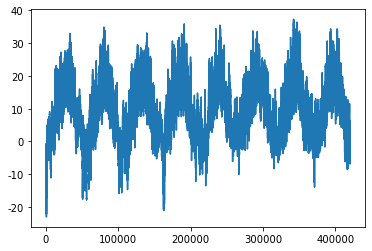

In [11]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

### 绘制前10天的温度时间序列

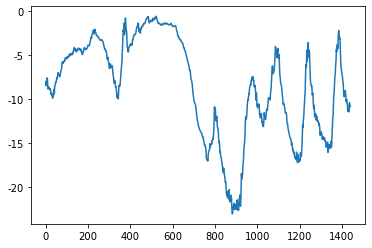

In [12]:
plt.plot(range(1440), temperature[:1440])

### 计算用于训练、验证和测试的样本数

In [14]:
num_train_samples = int(0.5*len(raw_data))
num_val_samples = int(0.25*len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## 二、准备数据

### 数据规范化

In [16]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [17]:
import numpy as np
from tensorflow import keras

In [20]:
int_sequence = np.arange(10) 
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i])) 

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2023-01-20 13:21:52.628114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
for samples1, targets1 in dummy_dataset:
     print("samples shape:", samples1.shape)
     print("targets shape:", targets1.shape)

samples shape: (2, 3)
targets shape: (2,)
samples shape: (2, 3)
targets shape: (2,)
samples shape: (1, 3)
targets shape: (1,)


In [24]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate*(sequence_length +24 -1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [25]:
for samples, targets in train_dataset:
     print("samples shape:", samples.shape)
     print("targets shape:", targets.shape)
     break

samples shape: (256, 120, 14)
targets shape: (256,)


### 计算基于常识的基准的MA

In [28]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]  #温度特征在第1列，所以samples[:, -1, 1]是输入序列最后一个温度测量值。之前我们对特征做了规范化，所以要得到以摄氏度为单位的温度值，还需要乘以标准差并加上均值，以实现规范化的逆操作
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 10.28
Test MAE: 10.40


### 基本的机器学习模型

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",  #这个回调函数用于保存具有最佳性能的模型
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")  # (本行及以下1行)重新加载最佳模型，并在测试数据上进行评估
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 14s 16ms/step - loss: 13.6762 - mae: 2.8462 - val_loss: 14.0224 - val_mae: 2.9541
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 9.1873 - mae: 2.3833 - val_loss: 11.8540 - val_mae: 2.7188
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 8.4598 - mae: 2.2873 - val_loss: 10.4323 - val_mae: 2.5382
Epoch 4/10
819/819 [==============================] - 14s 16ms/step - loss: 8.0436 - mae: 2.2297 - val_loss: 14.8352 - val_mae: 3.0946
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.7276 - mae: 2.1850 - val_loss: 11.3728 - val_mae: 2.6668
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 7.4796 - mae: 2.1489 - val_loss: 10.7310 - val_mae: 2.5817
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 7.2939 - mae: 2.1197 - val_loss: 12.9656 - val_mae: 2.8688
Epoch 8/10
819/819 [==============================] - 

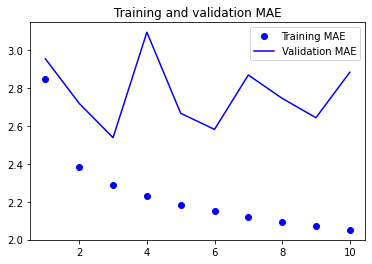

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 28s 33ms/step - loss: 21.7313 - mae: 3.6550 - val_loss: 16.1492 - val_mae: 3.1668
Epoch 2/10
819/819 [==============================] - 28s 34ms/step - loss: 15.4099 - mae: 3.1295 - val_loss: 14.1838 - val_mae: 2.9762
Epoch 3/10
819/819 [==============================] - 29s 35ms/step - loss: 14.2264 - mae: 3.0022 - val_loss: 14.1154 - val_mae: 2.9578
Epoch 4/10
819/819 [==============================] - 29s 36ms/step - loss: 13.3657 - mae: 2.9079 - val_loss: 13.5957 - val_mae: 2.8991
Epoch 5/10
819/819 [==============================] - 28s 35ms/step - loss: 12.7028 - mae: 2.8301 - val_loss: 13.9366 - val_mae: 2.9198
Epoch 6/10
819/819 [==============================] - 28s 34ms/step - loss: 12.1162 - mae: 2.7616 - val_loss: 13.8917 - val_mae: 2.9105
Epoch 7/10
819/819 [==============================] - 28s 34ms/step - loss: 11.6687 - mae: 2.7072 - val_loss: 14.2023 - val_mae: 2.9253
Epoch 8/10
819/819 [============================

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

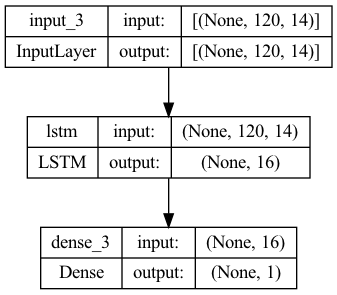

In [33]:
keras.utils.plot_model(model, "LSTM_temperature.png", show_shapes=True)

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 38.4783 - mae: 4.5067 - val_loss: 11.8628 - val_mae: 2.6238
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 10.8432 - mae: 2.5556 - val_loss: 9.5454 - val_mae: 2.3930
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 9.7495 - mae: 2.4281 - val_loss: 9.8197 - val_mae: 2.4244
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 9.2230 - mae: 2.3609 - val_loss: 9.7187 - val_mae: 2.4156
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 8.9230 - mae: 2.3207 - val_loss: 9.5645 - val_mae: 2.4048
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 8.7034 - mae: 2.2905 - val_loss: 9.6394 - val_mae: 2.4136
Epoch 7/10
819/819 [==============================] - 45s 54ms/step - loss: 8.5046 - mae: 2.2631 - val_loss: 9.8404 - val_mae: 2.4372
Epoch 8/10
819/819 [==============================] - 48s 5

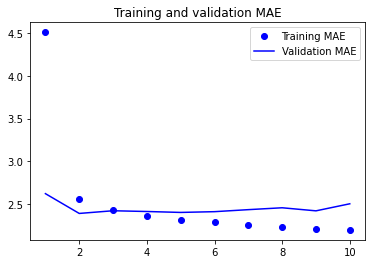

In [35]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()